In [27]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data_utils


import matplotlib.pyplot as plt
%matplotlib inline

import os, time
import numpy as np
import pandas as pd

In [7]:
dataset_path = os.path.join(str(os.getcwd()), '../data')

trainset = torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=False)
testset = torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=False)

dataset_path = os.path.join(dataset_path, 'cifar10/cifar-10-batches-py')
print(dataset_path)

data_list = os.listdir(dataset_path)
print(data_list)

/home/ubuntu/notebooks/pytorch/../data/cifar10/cifar-10-batches-py
['data_batch_3', 'data_batch_4', 'data_batch_5', 'test_batch', 'data_batch_1', 'data_batch_2', 'readme.html', 'batches.meta']


In [8]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as f:
        dict = pickle.load(f, encoding = 'bytes')
    return dict

batch_list = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']

In [21]:
train_set = None
train_lbs = None

for inst in batch_list:
    tmp_batch = unpickle(os.path.join(dataset_path, str(inst)))[b'data']
    tmp_batch = tmp_batch.reshape(tmp_batch.shape[0], 3, 32, 32) # batch size / channel / width / heights
    
    tmp_lbs = unpickle(os.path.join(dataset_path, str(inst)))[b'labels']
    if train_set is None:
        train_set = tmp_batch
        train_lbs = tmp_lbs
    else:
        train_set = np.append(train_set, tmp_batch, axis = 0)
        train_lbs = np.append(train_lbs, tmp_lbs, axis = 0)
        
test_set = unpickle(os.path.join(dataset_path, 'test_batch'))[b'data']
test_set = test_set.reshape(test_set.shape[0],3,32,32)
test_lbs = np.array(unpickle(os.path.join(dataset_path, 'test_batch'))[b'labels'])


print("loading is done")
print("train_set shape is {}".format(str(train_set.shape)))
print("train_lbs shape is {}".format(str(train_lbs.shape)))
print("test_set shape is {}".format(str(test_set.shape)))
print("test_lbs shape is {}".format(str(test_lbs.shape)))

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(classes)

loading is done
train_set shape is (50000, 3, 32, 32)
train_lbs shape is (50000,)
test_set shape is (10000, 3, 32, 32)
test_lbs shape is (10000,)
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [22]:
test_lbs

array([3, 8, 8, ..., 5, 1, 7])

(32, 32, 3)
frog


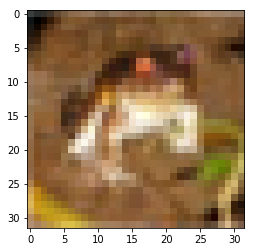

In [23]:
tmp_df = train_set[0]
tmp_df = tmp_df.transpose(1,2,0) # dimension 변경 : width / heights / channel
print(tmp_df.shape)

plt.imshow(tmp_df)
print(classes[train_lbs[0]])

In [24]:
np.max(train_set)

255

In [25]:
# data normalization
print(np.max(train_set))
print(np.min(train_set))

mean_v = np.mean(train_set/255)
print(mean_v)
std_v = np.std(train_set/255)
print(std_v)

# train_set의 mean / std 값으로 data normalization
train_set = (train_set/255 -mean_v)/std_v
test_set = (test_set/255 -mean_v)/std_v

print(np.mean(train_set))
print(np.std(train_set))
print(np.mean(test_set))
print(np.std(test_set))

255
0
0.4733630004850874
0.25156892506322026
9.83429634023499e-15
1.0000000000000042
0.0128073056421839
0.9986109795368511


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 32, 3)
frog


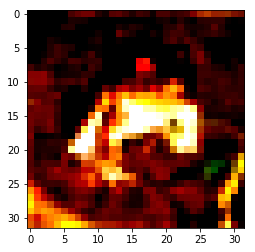

In [26]:
tmp_df = train_set[0]
tmp_df = tmp_df.transpose(1,2,0) # dimension 변경 : width / heights / channel
print(tmp_df.shape)

plt.imshow(tmp_df)
print(classes[train_lbs[0]])

In [30]:
# data loader

train = data_utils.TensorDataset(torch.tensor(train_set, dtype = torch.float), torch.tensor(train_lbs, dtype = torch.long))
train_loader = data_utils.DataLoader(train, batch_size = 10, shuffle=False, num_workers=2)

test = data_utils.TensorDataset(torch.tensor(test_set, dtype = torch.float), torch.tensor(test_lbs, dtype = torch.long))
test_loader = data_utils.DataLoader(test, batch_size = 10, shuffle=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10


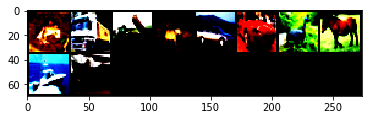

In [56]:
img, lb = iter(train_loader).next()
print(len(img))
plt.imshow(img[0].numpy().transpose(1,2,0))
plt.imshow(torchvision.utils.make_grid(img).numpy().transpose(1,2,0))

---
### building network
---

In [58]:
import torch.nn as nn
import torch.nn.functional as F

In [95]:
# line number -> L button
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5) # input : 3x32x32 -> output : 6x28x28
        self.pool = nn.MaxPool2d(2) # input : 6x28x28 -> output : 6x14x14
        self.conv2 = nn.Conv2d(6, 16, 5) # input : 6x14x14 -> output : 16x10x10
        
        self.fc1 = nn.Linear(16*5*5, 120) # conv2 이후 pool(2,2)를 거치기에 16*5*5
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [96]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [97]:
import torch.optim as optim

net_gpu = Net()
net_gpu.to(device) # all params. for network is on gpu device
print(net_gpu)

criterion = nn.CrossEntropyLoss()
opt = optim.SGD(net_gpu.parameters(), lr = 0.005)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [98]:
img, lb = iter(train_loader).next()
t = net_gpu(img[0,:].view(1,3,32,32).to(device))
print(t, torch.max(t, 1))
print(lb[0].item())

tensor([[ 0.0508, -0.0846,  0.1287,  0.0386, -0.0744, -0.0408,  0.0658, -0.0687,
         -0.0209, -0.0521]], device='cuda:0', grad_fn=<ThAddmmBackward>) (tensor([0.1287], device='cuda:0', grad_fn=<MaxBackward0>), tensor([2], device='cuda:0'))
6


In [100]:
t = time.time()

for epoch in range(5):
    
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        
        # zero grad
        opt.zero_grad()
        
        # forward + backward
        outs = net_gpu(inputs)
        loss = criterion(outs, labels)
        
        running_loss += loss
        
        loss.backward()
        opt.step()
        
        if i % 2000 == 1999:
            print('[%d, %d] loss : %.3f' % (epoch + 1, i + 1, running_loss/2000))
            running_loss = 0.0
            
elapsed = time.time() - t
print('elapsed time is {:.2f}s'.format(elapsed))

[1, 2000] loss : 2.233
[1, 4000] loss : 1.933
[2, 2000] loss : 1.633
[2, 4000] loss : 1.523
[3, 2000] loss : 1.423
[3, 4000] loss : 1.367
[4, 2000] loss : 1.304
[4, 4000] loss : 1.268
[5, 2000] loss : 1.221
[5, 4000] loss : 1.193
elapsed time is 66.90s


In [108]:
class_correct = [0. for i in range(10)]
class_total = [0. for i in range(10)]

with torch.no_grad():
    for data in test_loader:
        imgs, lbls = data[0].to(device), data[1]
        outs = net_gpu(imgs)
        _, preds = torch.max(outs, 1)
        lbls = lbls.long()
        c = (preds.to('cpu') == lbls).squeeze() # squeeze -> return to tensor
        
        # batch size
        for i in range(4):
            lb = lbls[i]
            class_correct[lb] += c[i].to('cpu').numpy()
            class_total[lb] += 1
            
for i in range(10):
    print("Accuracy of %3s : %2d %%" % (classes[i], 100*class_correct[i]/class_total[i]))

Accuracy of plane : 59 %
Accuracy of car : 85 %
Accuracy of bird : 34 %
Accuracy of cat : 36 %
Accuracy of deer : 59 %
Accuracy of dog : 37 %
Accuracy of frog : 59 %
Accuracy of horse : 70 %
Accuracy of ship : 62 %
Accuracy of truck : 58 %


In [111]:
print(net_gpu.conv1.weight.grad.size())
net_gpu.conv1.weight.grad

torch.Size([6, 3, 5, 5])


tensor([[[[ 0.4238,  0.4093,  0.3349,  0.2107,  0.1147],
          [ 0.4824,  0.4097,  0.3710,  0.3048,  0.2073],
          [ 0.4804,  0.4177,  0.3751,  0.3524,  0.2424],
          [ 0.5116,  0.4254,  0.3877,  0.3256,  0.2297],
          [ 0.4673,  0.4333,  0.3933,  0.3343,  0.2649]],

         [[ 0.4943,  0.4706,  0.3980,  0.2815,  0.1721],
          [ 0.5601,  0.4869,  0.4373,  0.3703,  0.2801],
          [ 0.5723,  0.5099,  0.4624,  0.4261,  0.3235],
          [ 0.5625,  0.4970,  0.4698,  0.4112,  0.3220],
          [ 0.5078,  0.4785,  0.4444,  0.3916,  0.3388]],

         [[ 0.5205,  0.4896,  0.4462,  0.3851,  0.3048],
          [ 0.5533,  0.5038,  0.4602,  0.4134,  0.3672],
          [ 0.5661,  0.5122,  0.4777,  0.4305,  0.3750],
          [ 0.5160,  0.4737,  0.4608,  0.4128,  0.3774],
          [ 0.4740,  0.4440,  0.4281,  0.3995,  0.3821]]],


        [[[ 0.1735,  0.1630,  0.1655,  0.1693,  0.1704],
          [ 0.1696,  0.1634,  0.1767,  0.2072,  0.2156],
          [ 0.2178,  0.

In [113]:
lbls[0].dtype

torch.int64

In [114]:
# model debugging : weight / grad 까보기 or 작은 데이터셋으로 하기 -> 작은 데이터셋으로 할 경우 정확도가 1이됨

In [122]:
np_test = np.array(range(100))
np_test = np_test.reshape(5,5,4)

np_test[0].shape

(5, 4)

In [125]:
print(np_test[0])
print(np_test[0, 0])

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]]
[0 1 2 3]


In [119]:
np_test[1]

array([[10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19]])